<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2021_0604Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.transforms import Compose
import sys
import os
import matplotlib.pyplot as plt
from collections import Counter
import random
import sys
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
train_transform = Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

test_transform = Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

cifar10_train = CIFAR10(root = "/data", train=True, download = True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=128, shuffle=True)

cifar10_test = CIFAR10(root = "/data", train=False, download = True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=128, shuffle=True)

cifar10 = CIFAR10(root = "/data", train=True, download = True)

y = cifar10.targets
X = cifar10.data

X_mean = torch.Tensor(np.mean(X,0))

print(X.shape)


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)


In [4]:
Counter(y)
#uniform distribution

Counter({0: 5000,
         1: 5000,
         2: 5000,
         3: 5000,
         4: 5000,
         5: 5000,
         6: 5000,
         7: 5000,
         8: 5000,
         9: 5000})

In [5]:
cifar10.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [6]:
def show_example(X, y, label, grid = (3,3)):
    y_label = [i for i, tag in enumerate(y) if label == tag]
    random.shuffle(y_label)
    
    rows = grid[0]
    columns = grid[1]
    
    fig, axes = plt.subplots(rows, columns)
    fig.set_figheight(7)
    fig.set_figwidth(7)
 
    for row in axes:
        for col in row:
            col.imshow(X[y_label.pop()])
    plt.show()

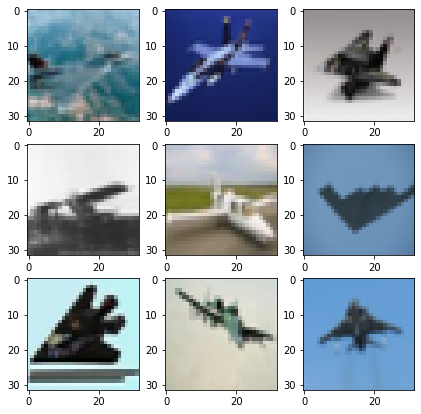

In [7]:
#airplane
show_example(X, y, 0)

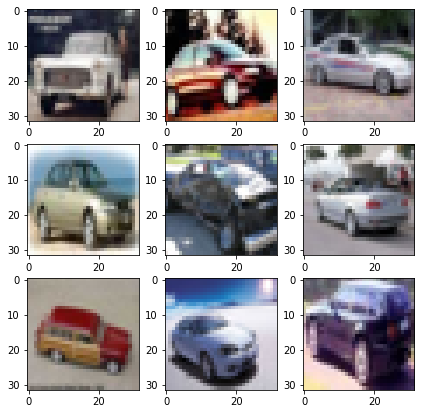

In [8]:
#automobile
show_example(X, y, 1)

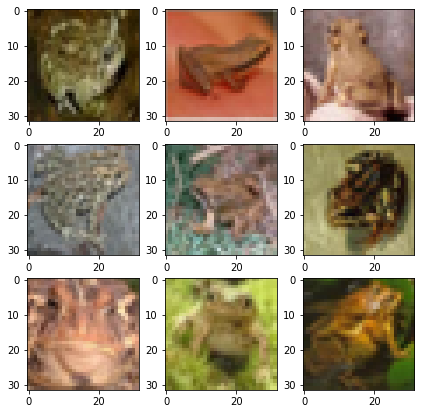

In [9]:
#frog
show_example(X, y, 6)

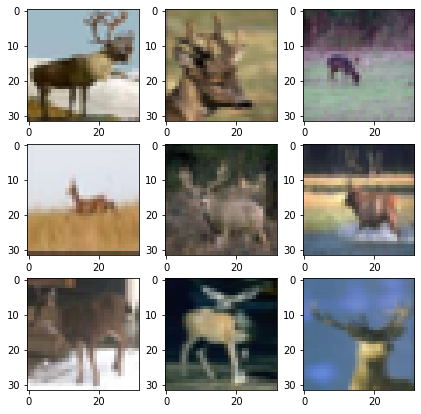

In [10]:
#deer
show_example(X, y, 4)

In [13]:
class _Block(nn.Module):
    def __init__(self, kernel_dim, n_filters, in_channels, stride, padding):
        super(_Block, self).__init__()
        self._layer_one = nn.Conv2d(in_channels=in_channels, out_channels=n_filters, 
                                  kernel_size=kernel_dim, stride=stride[0], padding=padding, bias=False)
        self._layer_two = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, 
                                  kernel_size=kernel_dim, stride=stride[1], padding=padding, bias=False)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.bn2 = nn.BatchNorm2d(n_filters)

    def forward(self, X, skip = None):
        h = self._layer_one(X)
        h = self.bn1(h)
        h = self.relu(h)
        h = self._layer_two(h)
        h = self.bn2(h)
        h = self.relu(h)
        if isinstance(skip, torch.Tensor):
            return h + skip
        return h + X


class ResNet(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(ResNet, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(3, 64, 4, 2)
        self.block1 = _Block(5, 64, 64, (1,1), 2)
        self.block2 = _Block(5, 64, 64, (1,1), 2)
        self.block3 = _Block(5, 64, 64, (1,1), 2)
        self.transition1 = nn.Conv2d(64, 128, 1, 2, 0, bias=False)
        self.block4 = _Block(3, 128, 64, (2,1), 1)
        self.block5 = _Block(3, 128, 128, (1,1), 1)
        self.block6 = _Block(3, 128, 128, (1,1), 1)
        self.transition2 = nn.Conv2d(128, 256, 3, 2, 1, bias=False)
        self.block7 = _Block(3, 256, 128, (2,1), 1)
        self.block8 = _Block(3, 256, 256, (1,1), 1)
        self.block9 = _Block(3, 256, 256, (1,1), 1)
        self.transition3 = nn.Conv2d(256, 512, 3, 2, 1, bias=False)
        self.block10 = _Block(3, 512, 256, (2,1), 1)
        self.block11 = _Block(3, 512, 512, (1,1), 1)
        self.block12 = _Block(3, 512, 512, (1,1), 1)
        self.linear1 = nn.Linear(2048, n_classes)


    def forward(self, X):
        h = self.conv1(X)
        h = self.block1(h)
        h = self.block2(h)
        h = self.block3(h)
        skip1 = self.transition1(h)
        h = self.block4(h, skip1)
        h = self.block5(h)
        h = self.block6(h)
        skip2 = self.transition2(h)
        h = self.block7(h, skip2)
        h = self.block8(h)
        h = self.block9(h)
        skip3 = self.transition3(h)
        h = self.block10(h, skip3)
        h = self.block11(h)
        h = self.block12(h)
        h = output.view(-1, 2048)
        h = self.linear1(h)
        return h



In [14]:
model = ResNet(32, 10)

In [15]:
test_input = torch.FloatTensor(X[0:1]).permute(0,3,2,1)
output = model(test_input)

In [16]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
LR = 0.001
optim = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=0.0001)

In [25]:
#EPOCHS = 20
max_epochs = 2
epoch_loss = []
val_loss = []
acc = []
train_time = 0

In [26]:
for i in range(max_epochs):
    start_time = time.time()
    ep = 0
    model.train()
    for X_b, y_b in train_loader:
        optim.zero_grad()
        X_b = X_b.to(device)
        y_b = y_b.to(device)

        output = model(X_b)

        loss = loss_fn(output, y_b)

        loss.backward()
        ep += loss.item()
        optim.step()
    epoch_loss.append(ep)
    train_time += time.time() - start_time
    print(f'Epoch {i+1}: 損失:{ep:.03f} 所要時間:{train_time:.2f}')
    
    correct = 0
    total = 0
    val = 0
    model.eval()
    for X_b, y_b in test_loader:
        X_b = X_b.to(device)
        y_b = y_b.to(device)
        output = model(X_b)
        loss = loss_fn(output, y_b)
        val += loss.item()
        probs = torch.functional.F.softmax(output, 1)
        label = torch.argmax(probs, dim=1)
        correct += torch.sum(label == y_b).item()
        total += y_b.shape[0]
    val_loss.append(val)
    acc.append(correct/total)
    
    print(f'精度: {correct:.3f} 検証データ損失: {val:.3f}')

print(f'--- 所要時間:{train_time} ---')

Epoch 1: 損失:210.028 所要時間:51.09
精度: 0.78 検証データ損失: 51.493
Epoch 2: 損失:201.411 所要時間:101.45
精度: 0.81 検証データ損失: 46.264
--- 所要時間:101.44793128967285 ---


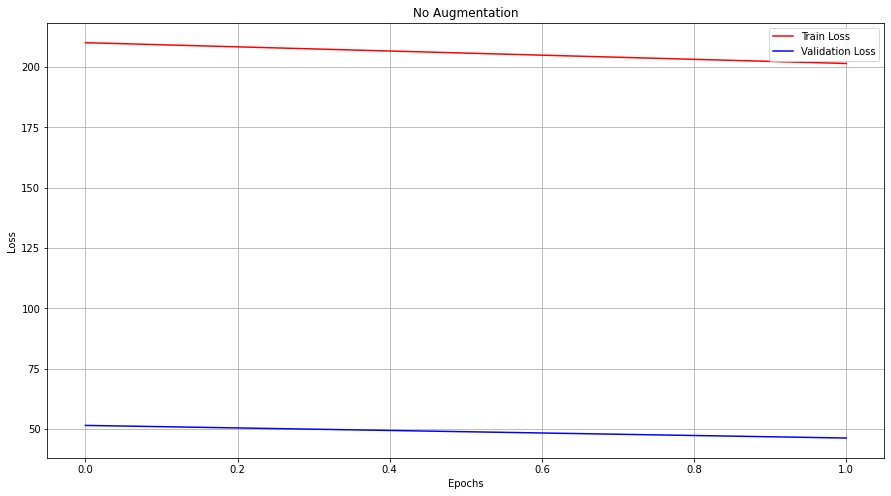

In [27]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(range(max_epochs), epoch_loss , color='r')
plt.plot(range(max_epochs), val_loss, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("No Augmentation")
ax.grid(True)

ValueError: ignored

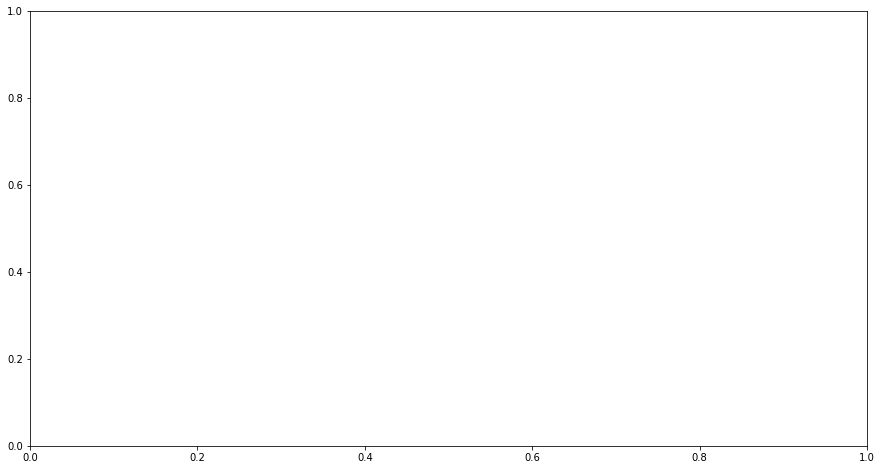

In [23]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(range(max_epochs), acc , color='g')
plt.legend(["Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("No Augmentation")
ax.grid(True)

In [ ]:
no_aug = [895.7, 602.43, 490.93, 411.63, 349.29, 300.45, 256.92, 213.5, 174.24, 144.04, 117.22, 98.63, 77.69, 77.81]
paper = [732.75, 557.27, 463.47, 339.8]

In [ ]:
B.shape

In [ ]:
C.shape

In [ ]:
t4d = torch.empty(3, 3, 4, 2)

In [ ]:
t4d[:2, :2, :, :].shape

In [ ]:
torch.sub()